20220920
Multilayer perceptron을 이용한 예측
- origin

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch


import matplotlib.pyplot as plt

%matplotlib inline

df = pd.read_csv('../data_up_delta.csv')
df.head()

,Unnamed: 0,receve comp time,printing start time,printing comp time,cutting start time,cutting comp time,pac time,T1,T2,T3,...,T5,X1,X2,X3,X4,Y0,X1_d1,X3_d1,X1_d2,X3_d2
0,2,2020-12-08 08:10:00,2020-12-08 08:10:00,2020-12-08 10:30:00,2020-12-08 10:35:00,2020-12-08 11:45:00,2020-12-08 17:10:00,0 days 02:20:00,0 days 00:05:00,0 days 01:10:00,...,0 days 09:00:00,140.0,5.0,70.0,325.0,540.0,140.0,70.0,140.0,70.0
1,3,2020-12-08 08:10:00,2020-12-08 08:10:00,2020-12-08 10:30:00,2020-12-08 10:35:00,2020-12-08 11:45:00,2020-12-08 17:10:00,0 days 02:20:00,0 days 00:05:00,0 days 01:10:00,...,0 days 09:00:00,140.0,5.0,70.0,325.0,540.0,140.0,70.0,140.0,70.0
2,4,2020-12-08 08:10:00,2020-12-08 08:10:00,2020-12-08 10:30:00,2020-12-08 10:35:00,2020-12-08 11:45:00,2020-12-08 17:10:00,0 days 02:20:00,0 days 00:05:00,0 days 01:10:00,...,0 days 09:00:00,140.0,5.0,70.0,325.0,540.0,140.0,70.0,140.0,70.0
3,5,2020-12-08 08:10:00,2020-12-08 08:10:00,2020-12-08 10:30:00,2020-12-08 10:35:00,2020-12-08 11:45:00,2020-12-08 17:10:00,0 days 02:20:00,0 days 00:05:00,0 days 01:10:00,...,0 days 09:00:00,140.0,5.0,70.0,325.0,540.0,140.0,70.0,140.0,70.0
4,6,2020-12-08 08:10:00,2020-12-08 08:10:00,2020-12-08 10:30:00,2020-12-08 10:35:00,2020-12-08 11:45:00,2020-12-08 17:10:00,0 days 02:20:00,0 days 00:05:00,0 days 01:10:00,...,0 days 09:00:00,140.0,5.0,70.0,325.0,540.0,140.0,70.0,140.0,70.0


In [2]:
input_data = pd.DataFrame()
input_data[['receve comp time', 'X1','X2','X3', 'X4', 'Y0']] = df[['receve comp time', 'X1','X2','X3', 'X4', 'Y0']]
input_data.head(5)

,receve comp time,X1,X2,X3,X4,Y0
0,2020-12-08 08:10:00,140.0,5.0,70.0,325.0,540.0
1,2020-12-08 08:10:00,140.0,5.0,70.0,325.0,540.0
2,2020-12-08 08:10:00,140.0,5.0,70.0,325.0,540.0
3,2020-12-08 08:10:00,140.0,5.0,70.0,325.0,540.0
4,2020-12-08 08:10:00,140.0,5.0,70.0,325.0,540.0


In [3]:
# 데이터 프레임.info() 함수는 데이터프레임에 관한 정보
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16992 entries, 0 to 16991
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   receve comp time  16992 non-null  object 
 1   X1                16992 non-null  float64
 2   X2                16992 non-null  float64
 3   X3                16992 non-null  float64
 4   X4                16992 non-null  float64
 5   Y0                16992 non-null  float64
dtypes: float64(5), object(1)
memory usage: 796.6+ KB


### x3 이전 값

In [43]:
x3_pre = pd.DataFrame()
x3_pre[['X3_pre']] = input_data[['X3']]
x3_push = pd.DataFrame()
x3_push[['X3_pre']] = x3_pre.iloc[:1]
x3_push = x3_push.append(x3_pre)
x3_push = x3_push.iloc[:-1]
x3_push = x3_push['X3_pre'].to_numpy()
x3_push

array([ 70.,  70.,  70., ..., 177.,  63.,  63.])

X1, X2, X3, X4 의 평균 구하기 추정할 때, 값이 없을 경우 평균으로 입력

In [4]:
X1_mean = df['X1'].mean()
X2_mean = df['X2'].mean()
X3_mean = df['X3'].mean()
X4_mean = df['X4'].mean()
Y0_mean = df['Y0'].mean()

print('X1 mean={:.2f}, X2 mean={:.2f}, X3 mean={:.2f}, X4 mean={:.2f}'.format(X1_mean, X2_mean, X3_mean, X4_mean))

X1 mean=123.99, X2 mean=5.05, X3 mean=130.89, X4 mean=10.54


In [5]:
# 데이터 셋을 target 기준으로 분리. Y0가 예측하려고 하는 값, X1, X2, X3 입력 변수 값
X = df[['X1','X2','X3', 'X4']].values
y = df['Y0'].values
print(X.shape, type(X))
print(y.shape, type(y))

(16992, 4) <class 'numpy.ndarray'>
(16992,) <class 'numpy.ndarray'>


In [6]:
# 80% training, 20% test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)



(13593, 4) (13593,)
(3399, 4) (3399,)


In [46]:
x3_pre = pd.DataFrame(x_test)
x3_pre.columns = ['X1', 'X2', 'X3', 'X4']
x3_pre = x3_pre[['X3']]
x3_push = pd.DataFrame()
x3_push[['X3']] = x3_pre.iloc[:1]
x3_push = x3_push.append(x3_pre)
x3_push = x3_push.iloc[:-1]
x3_push = x3_push['X3'].to_numpy()
x3_push

array([ 39.,  39.,  14., ...,   2.,   4., 137.])

데이터를 tensor 데이터형으로 변환

In [7]:
x_train_seq = torch.FloatTensor(x_train)
y_train_seq = torch.FloatTensor(y_train).view([-1, 1])
x_test_seq = torch.FloatTensor(x_test)
y_test_seq = torch.FloatTensor(y_test).view([-1, 1])
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([13593, 4]) torch.Size([13593, 1])
torch.Size([3399, 4]) torch.Size([3399, 1])


data loader 만들기

In [8]:
# 배치 형태로 만들어 주자. 시계열이니까 셔플을 막 하면 안된다
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)  # x_train 과 y_train 은 하나의 TensorDataset 으로 결합
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 50
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [9]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  TensorDataset, DataLoader

모델 만들기

In [15]:
relu = nn.ReLU()
linear1 = nn.Linear(4, 64, bias=True)
linear2 = nn.Linear(64, 512, bias=True)
linear3 = nn.Linear(512, 1024, bias=True)
linear33 = nn.Linear(1024, 2048, bias=True)
linear4 = nn.Linear(2048, 512, bias=True)
linear5 = nn.Linear(512, 32, bias=True)
linear6 = nn.Linear(32, 1, bias=True)

nn.init.xavier_uniform_(linear1.weight)
nn.init.xavier_uniform_(linear2.weight)
nn.init.xavier_uniform_(linear3.weight)
nn.init.xavier_uniform_(linear33.weight)
nn.init.xavier_uniform_(linear4.weight)
nn.init.xavier_uniform_(linear5.weight)
nn.init.xavier_uniform_(linear6.weight)

model = nn.Sequential(
    linear1, relu,
    linear2, relu,
    linear3, relu,
    linear33, relu,
    linear4, relu,
    linear5, relu,
    linear6
)

print(model)

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1024, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=2048, bias=True)
  (7): ReLU()
  (8): Linear(in_features=2048, out_features=512, bias=True)
  (9): ReLU()
  (10): Linear(in_features=512, out_features=32, bias=True)
  (11): ReLU()
  (12): Linear(in_features=32, out_features=1, bias=True)
)


In [16]:
import time
import os
import datetime
import os
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


num_epochs = 1000
batch_size = 50
learning_r = 1e-3
pwd = os.getcwd()
print(pwd)
model_name = os.path.join(pwd,'model/mlp-origin.model')
figure_name = os.path.join(pwd,'result/mlp-origin.png')
print(model_name, figure_name)

def training(model, train_dataloader):
    print("\nTraining is Started ")
    model.train()
    criterion = nn.MSELoss()       
    optimizer = optim.Adam(model.parameters(), lr=learning_r)  

    start_time = time.time()
    loss_graph = [] # 그래프 그릴 목적인 loss.
    n = len(train_loader)

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.
        for data in train_loader:
            seq, target = data
            out = model(seq)  
            loss = criterion(out, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        loss_graph.append(running_loss / n)
        if epoch % 10 == 0:
            print('[epoch: {}] loss: {:.4f}   Time: {}'.format(epoch, running_loss/n, datetime.datetime.now()))
    plt.figure(figsize=(20,10))
    plt.plot(loss_graph)
    plt.show()
    plt.savefig(figure_name)

    torch.save(model.state_dict(), model_name)
    print('    model_path={} is saved'.format(model_name))
    return


/sharehouse/DATA/SMART_FACTORY/ckim
/sharehouse/DATA/SMART_FACTORY/ckim/model/mlp-origin.model /sharehouse/DATA/SMART_FACTORY/ckim/result/mlp-origin.png


In [27]:
# err_range = 10.  # error range in hit ratio
def testing(model, test_loader, err_range): # all values / Y0
    print("\nTesting is Started ")

    model.eval()
    model.load_state_dict(torch.load(model_name))
    print('model is loaded')

    with torch.no_grad():
        test_pred = []
        test_actual = []
        for data in test_loader:
          seq, target = data
          out = model(seq)
          test_pred += out.numpy().tolist()
          test_actual += target.numpy().tolist()
    print(len(test_pred), len(test_actual))
    print(test_pred[10:20])
    print(test_actual[10:20])
    
    mse = np.sqrt(mean_squared_error(test_pred, test_actual))
    print('평균제곱근오차', mse)
    r2 = r2_score(test_pred, test_actual)
    print('결정계수', r2)
    
    # hit ratio    
    test_pred = np.array(test_pred)
    test_actual = np.array(test_actual)
    diff = np.absolute(test_pred - test_actual)
    hit_int = [0 if i - err_range < 0 else 1 for i in diff]

    err_no = np.array(hit_int).sum()
    total_test = len(test_pred)
    err_rat = err_no / total_test
    hit_rat = 1.0 - err_rat
    print('hit ratio with error range({:.2f}) = {:.4f}, no of errors = {}, total = {}'.format(err_range, hit_rat, err_no, total_test))
   
    return

In [28]:
def testing2(model, test_loader, x2, x3, x4, err_range): # X1, All mean values / Y0
    print("\nTesting is Started ")

    model.eval()
    model.load_state_dict(torch.load(model_name))
    print('model is loaded')

    with torch.no_grad():
        test_pred = []
        test_actual = []
        for data in test_loader:
          seq, target = data
          seq[:,1] = x2
          seq[:,2] = x3
          seq[:,3] = x4
          out = model(seq)
          test_pred += out.numpy().tolist()
          test_actual += target.numpy().tolist()
    print(len(test_pred), len(test_actual))
    mse = np.sqrt(mean_squared_error(test_pred, test_actual))
    print('평균제곱근오차', mse)
    r2 = r2_score(test_pred, test_actual)
    print('결정계수', r2)
    
    # hit ratio    
    test_pred = np.array(test_pred)
    test_actual = np.array(test_actual)
    diff = np.absolute(test_pred - test_actual)
    hit_int = [0 if i - err_range < 0 else 1 for i in diff]

    err_no = np.array(hit_int).sum()
    total_test = len(test_pred)
    err_rat = err_no / total_test
    hit_rat = 1.0 - err_rat
    print('hit ratio with error range({:.2f}) = {:.4f}, no of errors = {}, total = {}'.format(err_range, hit_rat, err_no, total_test))
   
    return

In [44]:
def testing3(model, test_loader, x2, x3, x4, err_range): # X1, X2 mean, X3 previous value, X4 mean / Y0
    print("\nTesting is Started ")

    model.eval()
    model.load_state_dict(torch.load(model_name))
    print('model is loaded')

    with torch.no_grad():
        test_pred = []
        test_actual = []
        for data, x3_pre in zip(test_loader, x3):
          seq, target = data
          #print(seq)
          seq[:,1] = x2
          seq[:,2] = x3_pre
          seq[:,3] = x4
          #print('---> ', seq)
        
          out = model(seq)
          test_pred += out.cpu().numpy().tolist()
          test_actual += target.cpu().numpy().tolist()
            
          x3_pre = x3
    print(len(test_pred), len(test_actual))
    mse = np.sqrt(mean_squared_error(test_pred, test_actual))
    print('평균제곱근오차', mse)
    r2 = r2_score(test_pred, test_actual)
    print('결정계수', r2)
    
    # hit ratio    
    test_pred = np.array(test_pred)
    test_actual = np.array(test_actual)
    diff = np.absolute(test_pred - test_actual)
    hit_int = [0 if i - err_range < 0 else 1 for i in diff]

    err_no = np.array(hit_int).sum()
    total_test = len(test_pred)
    err_rat = err_no / total_test
    hit_rat = 1.0 - err_rat
    print('hit ratio with error range({:.2f}) = {:.4f}, no of errors = {}, total = {}'.format(err_range, hit_rat, err_no, total_test))
   
    return

  0%|          | 0/1000 [00:00<?, ?it/s]


Training is Started 


  0%|          | 1/1000 [00:05<1:27:24,  5.25s/it]

[epoch: 0] loss: 4393.2575   Time: 2022-09-20 11:58:26.282162


  1%|          | 11/1000 [00:58<1:29:18,  5.42s/it]

[epoch: 10] loss: 213.5751   Time: 2022-09-20 11:59:19.734441


  2%|▏         | 21/1000 [01:53<1:28:48,  5.44s/it]

[epoch: 20] loss: 2403.0396   Time: 2022-09-20 12:00:14.166090


  3%|▎         | 31/1000 [02:47<1:27:18,  5.41s/it]

[epoch: 30] loss: 2128.9794   Time: 2022-09-20 12:01:08.329546


  4%|▍         | 41/1000 [03:41<1:26:25,  5.41s/it]

[epoch: 40] loss: 34.9273   Time: 2022-09-20 12:02:02.496066


  5%|▌         | 51/1000 [04:35<1:25:40,  5.42s/it]

[epoch: 50] loss: 246.7160   Time: 2022-09-20 12:02:56.620320


  6%|▌         | 61/1000 [05:28<1:22:39,  5.28s/it]

[epoch: 60] loss: 429.6368   Time: 2022-09-20 12:03:49.469708


  7%|▋         | 71/1000 [06:21<1:21:42,  5.28s/it]

[epoch: 70] loss: 4.6750   Time: 2022-09-20 12:04:42.057089


  8%|▊         | 81/1000 [07:14<1:21:44,  5.34s/it]

[epoch: 80] loss: 9.2695   Time: 2022-09-20 12:05:35.186146


  9%|▉         | 91/1000 [08:07<1:20:18,  5.30s/it]

[epoch: 90] loss: 1175.7263   Time: 2022-09-20 12:06:28.590009


 10%|█         | 101/1000 [08:59<1:17:41,  5.19s/it]

[epoch: 100] loss: 4.3977   Time: 2022-09-20 12:07:20.615522


 11%|█         | 111/1000 [09:51<1:17:41,  5.24s/it]

[epoch: 110] loss: 1.5664   Time: 2022-09-20 12:08:12.170292


 12%|█▏        | 121/1000 [10:44<1:17:58,  5.32s/it]

[epoch: 120] loss: 2.1825   Time: 2022-09-20 12:09:05.392731


 13%|█▎        | 131/1000 [11:37<1:17:48,  5.37s/it]

[epoch: 130] loss: 83.9605   Time: 2022-09-20 12:09:58.960066


 14%|█▍        | 141/1000 [12:31<1:16:51,  5.37s/it]

[epoch: 140] loss: 60.1215   Time: 2022-09-20 12:10:52.621574


 15%|█▌        | 151/1000 [13:23<1:12:51,  5.15s/it]

[epoch: 150] loss: 126.8348   Time: 2022-09-20 12:11:44.683875


 16%|█▌        | 161/1000 [14:15<1:12:47,  5.21s/it]

[epoch: 160] loss: 8.0948   Time: 2022-09-20 12:12:36.401213


 17%|█▋        | 171/1000 [15:06<1:10:27,  5.10s/it]

[epoch: 170] loss: 29.0135   Time: 2022-09-20 12:13:27.320757


 18%|█▊        | 181/1000 [15:56<1:09:10,  5.07s/it]

[epoch: 180] loss: 61.5307   Time: 2022-09-20 12:14:17.531478


 19%|█▉        | 191/1000 [16:49<1:11:18,  5.29s/it]

[epoch: 190] loss: 36.9058   Time: 2022-09-20 12:15:10.340656


 20%|██        | 201/1000 [17:41<1:08:53,  5.17s/it]

[epoch: 200] loss: 63.0986   Time: 2022-09-20 12:16:02.676837


 21%|██        | 211/1000 [18:35<1:11:19,  5.42s/it]

[epoch: 210] loss: 11.2419   Time: 2022-09-20 12:16:56.284929


 22%|██▏       | 221/1000 [19:30<1:12:05,  5.55s/it]

[epoch: 220] loss: 129.9502   Time: 2022-09-20 12:17:51.532465


 23%|██▎       | 231/1000 [20:25<1:10:24,  5.49s/it]

[epoch: 230] loss: 33.6556   Time: 2022-09-20 12:18:46.589904


 24%|██▍       | 241/1000 [21:22<1:11:53,  5.68s/it]

[epoch: 240] loss: 74.3520   Time: 2022-09-20 12:19:43.172124


 25%|██▌       | 251/1000 [22:19<1:11:08,  5.70s/it]

[epoch: 250] loss: 478.1463   Time: 2022-09-20 12:20:40.233608


 26%|██▌       | 261/1000 [23:19<1:15:42,  6.15s/it]

[epoch: 260] loss: 346.2163   Time: 2022-09-20 12:21:40.634332


 27%|██▋       | 271/1000 [24:22<1:16:20,  6.28s/it]

[epoch: 270] loss: 137.2400   Time: 2022-09-20 12:22:43.227713


 28%|██▊       | 281/1000 [25:27<1:18:40,  6.57s/it]

[epoch: 280] loss: 37.1139   Time: 2022-09-20 12:23:48.668648


 29%|██▉       | 291/1000 [26:36<1:21:46,  6.92s/it]

[epoch: 290] loss: 5.4336   Time: 2022-09-20 12:24:57.053874


 30%|███       | 301/1000 [27:47<1:23:45,  7.19s/it]

[epoch: 300] loss: 13.7273   Time: 2022-09-20 12:26:08.823614


 31%|███       | 311/1000 [29:04<1:30:14,  7.86s/it]

[epoch: 310] loss: 1.5362   Time: 2022-09-20 12:27:25.203967


 32%|███▏      | 321/1000 [30:25<1:33:32,  8.27s/it]

[epoch: 320] loss: 32.0824   Time: 2022-09-20 12:28:46.101375


 33%|███▎      | 331/1000 [31:54<1:41:18,  9.09s/it]

[epoch: 330] loss: 65.7911   Time: 2022-09-20 12:30:15.111866


 34%|███▍      | 341/1000 [33:32<1:51:07, 10.12s/it]

[epoch: 340] loss: 4.2932   Time: 2022-09-20 12:31:54.032429


 35%|███▌      | 351/1000 [35:19<1:56:40, 10.79s/it]

[epoch: 350] loss: 76.1298   Time: 2022-09-20 12:33:40.711923


 36%|███▌      | 361/1000 [37:10<1:58:57, 11.17s/it]

[epoch: 360] loss: 65.2458   Time: 2022-09-20 12:35:31.799312


 37%|███▋      | 371/1000 [39:04<1:59:13, 11.37s/it]

[epoch: 370] loss: 1.0912   Time: 2022-09-20 12:37:25.143174


 38%|███▊      | 381/1000 [40:58<1:57:58, 11.44s/it]

[epoch: 380] loss: 76.8397   Time: 2022-09-20 12:39:19.277316


 39%|███▉      | 391/1000 [42:52<1:56:09, 11.44s/it]

[epoch: 390] loss: 4.3952   Time: 2022-09-20 12:41:13.655849


 40%|████      | 401/1000 [44:47<1:55:17, 11.55s/it]

[epoch: 400] loss: 23.4068   Time: 2022-09-20 12:43:08.917563


 41%|████      | 411/1000 [46:43<1:53:24, 11.55s/it]

[epoch: 410] loss: 7.3027   Time: 2022-09-20 12:45:04.507961


 42%|████▏     | 421/1000 [48:40<1:52:33, 11.66s/it]

[epoch: 420] loss: 5.8592   Time: 2022-09-20 12:47:01.148666


 43%|████▎     | 431/1000 [50:36<1:50:08, 11.61s/it]

[epoch: 430] loss: 32.2704   Time: 2022-09-20 12:48:57.393278


 44%|████▍     | 441/1000 [52:32<1:48:14, 11.62s/it]

[epoch: 440] loss: 136.6112   Time: 2022-09-20 12:50:53.481004


 45%|████▌     | 451/1000 [54:27<1:45:36, 11.54s/it]

[epoch: 450] loss: 22.9914   Time: 2022-09-20 12:52:48.980638


 46%|████▌     | 461/1000 [56:22<1:43:29, 11.52s/it]

[epoch: 460] loss: 7.1573   Time: 2022-09-20 12:54:44.018038


 47%|████▋     | 471/1000 [58:19<1:42:19, 11.60s/it]

[epoch: 470] loss: 87.8972   Time: 2022-09-20 12:56:40.095100


 48%|████▊     | 481/1000 [1:00:15<1:40:07, 11.57s/it]

[epoch: 480] loss: 57.9908   Time: 2022-09-20 12:58:36.222143


 49%|████▉     | 491/1000 [1:02:10<1:37:46, 11.53s/it]

[epoch: 490] loss: 3.2440   Time: 2022-09-20 13:00:31.564488


 50%|█████     | 501/1000 [1:04:05<1:35:36, 11.50s/it]

[epoch: 500] loss: 2.4857   Time: 2022-09-20 13:02:26.327349


 51%|█████     | 511/1000 [1:06:00<1:33:48, 11.51s/it]

[epoch: 510] loss: 445.6654   Time: 2022-09-20 13:04:21.369662


 52%|█████▏    | 521/1000 [1:07:55<1:32:05, 11.53s/it]

[epoch: 520] loss: 23.0942   Time: 2022-09-20 13:06:16.929468


 53%|█████▎    | 531/1000 [1:09:51<1:29:56, 11.51s/it]

[epoch: 530] loss: 67.2630   Time: 2022-09-20 13:08:12.129544


 54%|█████▍    | 541/1000 [1:11:46<1:27:53, 11.49s/it]

[epoch: 540] loss: 3.0927   Time: 2022-09-20 13:10:07.036768


 55%|█████▌    | 551/1000 [1:13:40<1:26:00, 11.49s/it]

[epoch: 550] loss: 96.6481   Time: 2022-09-20 13:12:01.942785


 56%|█████▌    | 561/1000 [1:15:35<1:24:15, 11.52s/it]

[epoch: 560] loss: 55.7837   Time: 2022-09-20 13:13:56.946170


 57%|█████▋    | 571/1000 [1:17:30<1:22:04, 11.48s/it]

[epoch: 570] loss: 3.7993   Time: 2022-09-20 13:15:51.609850


 58%|█████▊    | 581/1000 [1:19:26<1:20:37, 11.54s/it]

[epoch: 580] loss: 7.4116   Time: 2022-09-20 13:17:47.155010


 59%|█████▉    | 591/1000 [1:21:20<1:17:55, 11.43s/it]

[epoch: 590] loss: 29.1703   Time: 2022-09-20 13:19:41.484276


 60%|██████    | 601/1000 [1:23:14<1:15:51, 11.41s/it]

[epoch: 600] loss: 12.5350   Time: 2022-09-20 13:21:35.840822


 61%|██████    | 611/1000 [1:25:09<1:14:59, 11.57s/it]

[epoch: 610] loss: 1.8596   Time: 2022-09-20 13:23:30.984809


 62%|██████▏   | 621/1000 [1:27:05<1:13:01, 11.56s/it]

[epoch: 620] loss: 1.7949   Time: 2022-09-20 13:25:26.553627


 63%|██████▎   | 631/1000 [1:29:01<1:11:26, 11.62s/it]

[epoch: 630] loss: 16.4864   Time: 2022-09-20 13:27:22.574215


 64%|██████▍   | 641/1000 [1:30:58<1:09:37, 11.64s/it]

[epoch: 640] loss: 1.9478   Time: 2022-09-20 13:29:19.158605


 65%|██████▌   | 651/1000 [1:32:54<1:07:29, 11.60s/it]

[epoch: 650] loss: 1.2469   Time: 2022-09-20 13:31:15.358440


 66%|██████▌   | 661/1000 [1:34:51<1:05:51, 11.66s/it]

[epoch: 660] loss: 10.0591   Time: 2022-09-20 13:33:12.112028


 67%|██████▋   | 671/1000 [1:36:47<1:03:52, 11.65s/it]

[epoch: 670] loss: 84.1281   Time: 2022-09-20 13:35:08.657330


 68%|██████▊   | 681/1000 [1:38:44<1:02:01, 11.67s/it]

[epoch: 680] loss: 3.4024   Time: 2022-09-20 13:37:05.423406


 69%|██████▉   | 691/1000 [1:40:40<59:56, 11.64s/it]  

[epoch: 690] loss: 51.5590   Time: 2022-09-20 13:39:01.554230


 70%|███████   | 701/1000 [1:42:36<58:00, 11.64s/it]

[epoch: 700] loss: 100.1739   Time: 2022-09-20 13:40:57.862760


 71%|███████   | 711/1000 [1:44:32<55:55, 11.61s/it]

[epoch: 710] loss: 73.7099   Time: 2022-09-20 13:42:53.966014


 72%|███████▏  | 721/1000 [1:46:28<53:47, 11.57s/it]

[epoch: 720] loss: 13.9213   Time: 2022-09-20 13:44:50.001014


 73%|███████▎  | 731/1000 [1:48:24<51:40, 11.52s/it]

[epoch: 730] loss: 66.0851   Time: 2022-09-20 13:46:45.705462


 74%|███████▍  | 741/1000 [1:50:21<50:19, 11.66s/it]

[epoch: 740] loss: 244.1537   Time: 2022-09-20 13:48:42.050431


 75%|███████▌  | 751/1000 [1:52:18<48:23, 11.66s/it]

[epoch: 750] loss: 27.9550   Time: 2022-09-20 13:50:39.098631


 76%|███████▌  | 761/1000 [1:54:15<46:41, 11.72s/it]

[epoch: 760] loss: 79.2697   Time: 2022-09-20 13:52:36.198832


 77%|███████▋  | 771/1000 [1:56:12<44:53, 11.76s/it]

[epoch: 770] loss: 9.6063   Time: 2022-09-20 13:54:33.596960


 78%|███████▊  | 781/1000 [1:58:09<42:39, 11.69s/it]

[epoch: 780] loss: 30.7603   Time: 2022-09-20 13:56:30.600506


 79%|███████▉  | 791/1000 [2:00:05<40:16, 11.56s/it]

[epoch: 790] loss: 2.5851   Time: 2022-09-20 13:58:26.738325


 80%|████████  | 801/1000 [2:02:01<38:41, 11.67s/it]

[epoch: 800] loss: 23.6376   Time: 2022-09-20 14:00:22.971393


 81%|████████  | 811/1000 [2:03:59<36:47, 11.68s/it]

[epoch: 810] loss: 6.3997   Time: 2022-09-20 14:02:20.429655


 82%|████████▏ | 821/1000 [2:05:56<35:03, 11.75s/it]

[epoch: 820] loss: 50.6675   Time: 2022-09-20 14:04:17.691655


 83%|████████▎ | 831/1000 [2:07:53<32:54, 11.69s/it]

[epoch: 830] loss: 20.2000   Time: 2022-09-20 14:06:14.594384


 84%|████████▍ | 841/1000 [2:09:50<31:04, 11.73s/it]

[epoch: 840] loss: 2.3168   Time: 2022-09-20 14:08:11.349535


 85%|████████▌ | 851/1000 [2:11:47<29:07, 11.73s/it]

[epoch: 850] loss: 3.2348   Time: 2022-09-20 14:10:08.717554


 86%|████████▌ | 861/1000 [2:13:44<27:11, 11.74s/it]

[epoch: 860] loss: 5.7686   Time: 2022-09-20 14:12:06.023232


 87%|████████▋ | 871/1000 [2:15:41<25:02, 11.65s/it]

[epoch: 870] loss: 4.2736   Time: 2022-09-20 14:14:02.809735


 88%|████████▊ | 881/1000 [2:17:37<23:01, 11.61s/it]

[epoch: 880] loss: 35.6465   Time: 2022-09-20 14:15:58.942727


 89%|████████▉ | 891/1000 [2:19:33<20:51, 11.48s/it]

[epoch: 890] loss: 17.5529   Time: 2022-09-20 14:17:54.128129


 90%|█████████ | 901/1000 [2:21:28<19:14, 11.66s/it]

[epoch: 900] loss: 3.3938   Time: 2022-09-20 14:19:50.001706


 91%|█████████ | 911/1000 [2:23:25<17:14, 11.62s/it]

[epoch: 910] loss: 2.4461   Time: 2022-09-20 14:21:46.164447


 92%|█████████▏| 921/1000 [2:25:21<15:15, 11.59s/it]

[epoch: 920] loss: 65.9892   Time: 2022-09-20 14:23:42.462322


 93%|█████████▎| 931/1000 [2:27:18<13:25, 11.67s/it]

[epoch: 930] loss: 1.4920   Time: 2022-09-20 14:25:39.082992


 94%|█████████▍| 941/1000 [2:29:14<11:29, 11.69s/it]

[epoch: 940] loss: 12.7653   Time: 2022-09-20 14:27:35.962409


 95%|█████████▌| 951/1000 [2:31:11<09:24, 11.53s/it]

[epoch: 950] loss: 2.7502   Time: 2022-09-20 14:29:32.164217


 96%|█████████▌| 961/1000 [2:33:07<07:36, 11.71s/it]

[epoch: 960] loss: 26.1540   Time: 2022-09-20 14:31:28.067339


 97%|█████████▋| 971/1000 [2:35:03<05:38, 11.67s/it]

[epoch: 970] loss: 41.6878   Time: 2022-09-20 14:33:25.015842


 98%|█████████▊| 981/1000 [2:37:00<03:41, 11.64s/it]

[epoch: 980] loss: 50.6846   Time: 2022-09-20 14:35:21.515539


 99%|█████████▉| 991/1000 [2:38:56<01:45, 11.69s/it]

[epoch: 990] loss: 2.1933   Time: 2022-09-20 14:37:17.918505


100%|██████████| 1000/1000 [2:40:43<00:00,  9.64s/it]


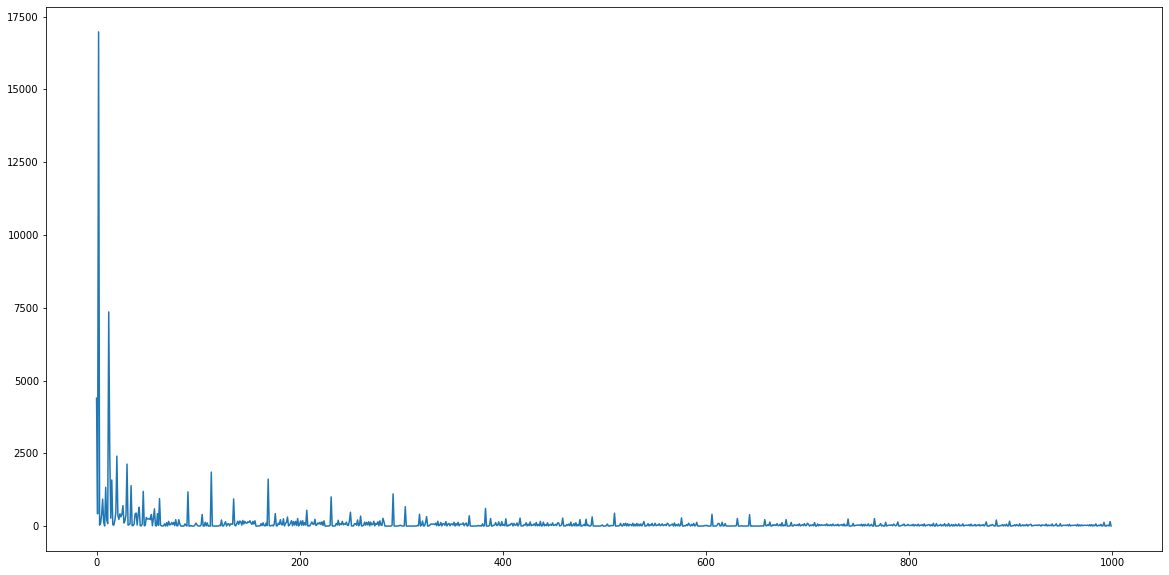

    model_path=/sharehouse/DATA/SMART_FACTORY/ckim/model/mlp-origin.model is saved


<Figure size 432x288 with 0 Axes>

In [18]:
training(model, train_loader)

In [30]:
model.eval()

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1024, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=2048, bias=True)
  (7): ReLU()
  (8): Linear(in_features=2048, out_features=512, bias=True)
  (9): ReLU()
  (10): Linear(in_features=512, out_features=32, bias=True)
  (11): ReLU()
  (12): Linear(in_features=32, out_features=1, bias=True)
)

In [31]:
model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [32]:
testing(model, test_loader, 10.)
testing(model, test_loader, 30.)


Testing is Started 
model is loaded
3399 3399
[[324.9588623046875], [121.01998901367188], [184.9327850341797], [206.95803833007812], [493.6793212890625], [154.97093200683594], [241.92483520507812], [149.01611328125], [263.8922424316406], [174.9835662841797]]
[[325.0], [121.0], [185.0], [207.0], [494.0], [155.0], [242.0], [149.0], [264.0], [175.0]]
평균제곱근오차 1.0341691296117355
결정계수 0.9999931030040558
hit ratio with error range(10.00) = 0.9997, no of errors = 1, total = 3399

Testing is Started 
model is loaded
3399 3399
[[324.9588623046875], [121.01998901367188], [184.9327850341797], [206.95803833007812], [493.6793212890625], [154.97093200683594], [241.92483520507812], [149.01611328125], [263.8922424316406], [174.9835662841797]]
[[325.0], [121.0], [185.0], [207.0], [494.0], [155.0], [242.0], [149.0], [264.0], [175.0]]
평균제곱근오차 1.0341691296117355
결정계수 0.9999931030040558
hit ratio with error range(30.00) = 0.9997, no of errors = 1, total = 3399


In [33]:
testing2(model, test_loader, X2_mean, X3_mean, X4_mean, 10.)
testing2(model, test_loader, X2_mean, X3_mean, X4_mean, 30.)


Testing is Started 
model is loaded
3399 3399
평균제곱근오차 360.9695677270396
결정계수 -12.98922081457306
hit ratio with error range(10.00) = 0.0374, no of errors = 3272, total = 3399

Testing is Started 
model is loaded
3399 3399
평균제곱근오차 360.9695677270396
결정계수 -12.98922081457306
hit ratio with error range(30.00) = 0.1315, no of errors = 2952, total = 3399


In [47]:
testing3(model, test_loader, X2_mean, x3_push, X4_mean, 10.)
testing3(model, test_loader, X2_mean, x3_push, X4_mean, 30.)


Testing is Started 
model is loaded
3399 3399
평균제곱근오차 726.6187312973732
결정계수 -0.3296096723715507
hit ratio with error range(10.00) = 0.1147, no of errors = 3009, total = 3399

Testing is Started 
model is loaded
3399 3399
평균제곱근오차 726.6187312973732
결정계수 -0.3296096723715507
hit ratio with error range(30.00) = 0.3086, no of errors = 2350, total = 3399


In [37]:
ran = [200, 400, 600, 800, 1000]
for i in ran:
    print(i, x_test[i], y_test[i])
    print(i-1, x_test[i-1], y_test[i-1])
    print('    mean = ', x_test[i-5:i].mean(axis=0))
print()


200 [254.   5.  82.  10.] 351.0
199 [367.   5. 290.  10.] 672.0
    mean =  [192.6   5.  224.4  10. ]
400 [159.   5.   3.  10.] 177.0
399 [ 86.   5. 220.  10.] 321.0
    mean =  [ 92.8   5.  123.6  10. ]
600 [58.  5. 42. 10.] 115.0
599 [336.   5.  46.  10.] 397.0
    mean =  [202.2   5.  108.8  10. ]
800 [147.   5. 230.  10.] 392.0
799 [101.   5.  46.  10.] 162.0
    mean =  [262.6   5.  166.6  10. ]
1000 [48.  5. 15. 10.] 78.0
999 [250.   5.   8.  10.] 273.00000000000006
    mean =  [125.    5.   43.4  10. ]



Sample test

In [38]:
X1_val = 169.
X2_val = 5.
X3_val = 13.
X4_val = 10.
Y0_val = 197.
X1_d1_val = 101.
X3_d1_val = 93.
print('X1={:.2f}, X2={:.2f}, X3={:.2f}, X4={:.2f}, Y0={:.2f}'.format(X1_val, X2_val, X3_val,X4_val,Y0_val))
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X1, X2, X3, X4 are known value, ', predict_val[0])
X2_val = X2_mean
X3_val = X3_mean
X4_val = X4_mean
X1_d1_val = X1_d1_mean
X3_d1_val = X3_d1_mean
X1_d2_val = X1_d2_mean
X3_d2_val = X3_d2_mean
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val, X1_d2_val, X3_d2_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])
X2_val = 5
X3_val = 18
X4_val = 10
X1_d1_val = 89
X3_d1_val = 18
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X1=169.00, X2=5.00, X3=13.00, X4=10.00, Y0=197.00


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x6 and 4x64)

In [39]:
X1_val = 29.
X2_val = 5.
X3_val = 28.
X4_val = 10.
Y0_val = 72.
X1_d1_val = 154.
X1_d2_val = 29.
X3_d1_val = 12.
X3_d2_val = 28.
print('X1={:.2f}, X2={:.2f}, X3={:.2f}, X4={:.2f}, Y0={:.2f}'.format(X1_val, X2_val, X3_val,X4_val,Y0_val))
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X1, X2, X3, X4 are known value, ', predict_val[0])
X2_val = X2_mean
X3_val = X3_mean
X4_val = X4_mean
X1_d1_val = X1_d1_mean
X3_d1_val = X3_d1_mean
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X2_val = 5.
X3_val = 375.
X4_val = 10.
X1_d1_val = 48.
X3_d1_val = 57
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X1=29.00, X2=5.00, X3=28.00, X4=10.00, Y0=72.00


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x6 and 4x64)

In [40]:
X1_val = 117.
X2_val = 5.
X3_val = 126.
X4_val = 10.
Y0_val = 258.
X1_d1_val = 76.
X3_d1_val = 17.
print('X1={:.2f}, X2={:.2f}, X3={:.2f}, X4={:.2f}, Y0={:.2f}'.format(X1_val, X2_val, X3_val,X4_val,Y0_val))
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X1, X2, X3, X4 are known value, ', predict_val[0])
X2_val = X2_mean
X3_val = X3_mean
X4_val = X4_mean
X1_d1_val = X1_d1_mean
X3_d1_val = X3_d1_mean
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X2_val = 5.
X3_val = 105.
X4_val = 10.
X1_d1_val = 122.
X1_d2_val = 66.
X3_d1_val = 85.
X3_d2_val = 9.
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X1=117.00, X2=5.00, X3=126.00, X4=10.00, Y0=258.00


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x6 and 4x64)

In [41]:
X1_val = 95.
X2_val = 5.
X3_val = 6.
X4_val = 10.
Y0_val = 116.
X1_d1_val = 175.
X3_d1_val = 11.
print('X1={:.2f}, X2={:.2f}, X3={:.2f}, X4={:.2f}, Y0={:.2f}'.format(X1_val, X2_val, X3_val, X4_val,Y0_val))
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X1, X2, X3, X4 are known value, ', predict_val[0])
X2_val = X2_mean
X3_val = X3_mean
X4_val = X4_mean
X1_d1_val = X1_d1_mean
X3_d1_val = X3_d1_mean
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X2_val = 5.
X3_val = 17.
X4_val = 10.
X1_d1_val = 167.
X3_d1_val = 17.
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X1=95.00, X2=5.00, X3=6.00, X4=10.00, Y0=116.00


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x6 and 4x64)

In [42]:
X1_val = 152.
X2_val = 5.
X3_val = 55.
X4_val = 10.
Y0_val = 222.
X1_d1_val = 282.
X3_d1_val = 259.
print('X1={:.2f}, X2={:.2f}, X3={:.2f}, X4={:.2f}, Y0={:.2f}'.format(X1_val, X2_val, X3_val,X4_val,Y0_val))
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X1, X2, X3, X4 are known value, ', predict_val[0])
X2_val = X2_mean
X3_val = X3_mean
X4_val = X4_mean
X1_d1_val = X1_d1_mean
X3_d1_val = X3_d1_mean
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X2_val = 5.
X3_val = 55.
X4_val = 10.
X1_d1_val = 382.
X3_d1_val = 359.
my_value = torch.FloatTensor([[X1_val, X2_val, X3_val, X4_val, X1_d1_val, X3_d1_val]])
my_predict = model(my_value).detach().numpy()
predict_val = np.ravel(my_predict)
print('X2, X3, X4 are mean value, ', predict_val[0])

X1=152.00, X2=5.00, X3=55.00, X4=10.00, Y0=222.00


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x6 and 4x64)